# Predictive Maintenance with Azure Dataset

## Project imports

In [1]:
import numpy as np
import pandas as pd

## Data Imports

Needs pre-processing.ipynb to be run first

In [2]:
def read(name: str, parse_dates: list[str] | None = ["datetime"]) -> pd.DataFrame:
    path = "data/"
    ext = ".csv"
    file = path + name + ext
    return pd.read_csv(file, parse_dates=parse_dates, na_values="NaN")


VARIABLES = ["volt", "rotate", "pressure", "vibration"]
DATA = read("raw_data").dropna(subset=VARIABLES)
normal_behavior_data = read("preprocessing/expected_behavior")
abnormal_data = read("preprocessing/failures_only")

print(DATA.shape)

(877209, 11)


## Classification

### Pre-processing

In [3]:
preprocessed_data = DATA.drop(
    columns=["datetime", "machineID", "failure", "model", "age", "errorID", "comp"]
).reset_index(drop=True)
print(preprocessed_data.shape)

labels = DATA[["failure"]].fillna("normal").reset_index(drop=True)
labels["failure_type"] = labels["failure"]
unique_failures = labels[labels["failure"] != "normal"]["failure"].unique()
for failure_type in unique_failures:
    labels[failure_type] = 0

time_before_failure = {failure: 0 for failure in unique_failures if failure != "normal"}
last_failure = ""
failure_window = 48

for i in range(len(labels) - 1, -1, -1):
    current_failure = labels.at[i, "failure"]
    time_before_failure = {k: v + 1 for k, v in time_before_failure.items()}

    if current_failure != "normal":
        time_before_failure[current_failure] = 0
        last_failure = current_failure
        labels.at[i, "failure"] = 0
    else:
        least_time = min(time_before_failure.values())
        labels.at[i, "failure"] = least_time
        if least_time <= failure_window:
            labels.at[i, "failure_type"] = last_failure

    for failure_type, time in time_before_failure.items():
        labels.at[i, failure_type] = time

labels.to_csv("data/preprocessing/final_labels.csv", index=False)
print(labels.shape)
assert labels.shape[0] == preprocessed_data.shape[0]

(877209, 4)
(877209, 6)


### Statistical values

In [4]:
window = 120

indices = labels[labels["failure"] > window].index
filtered_data = preprocessed_data.iloc[indices]

healthy_avgs = np.mean(filtered_data, axis=0)
print(f"Averages for each column where failure > {window}:\n{healthy_avgs}")

Averages for each column where failure > 120:
volt         170.560281
rotate       447.818687
pressure     100.665428
vibration     40.284227
dtype: float64


### Graphical failure representations

- Before failure

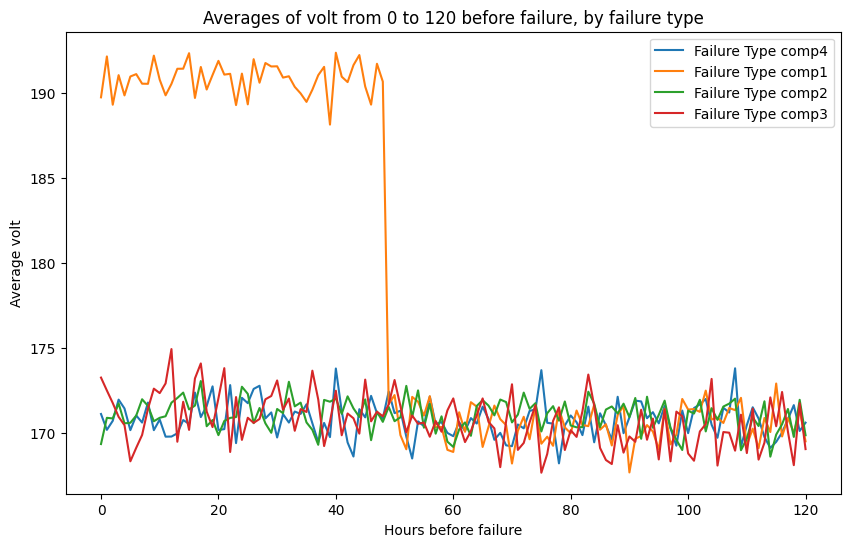

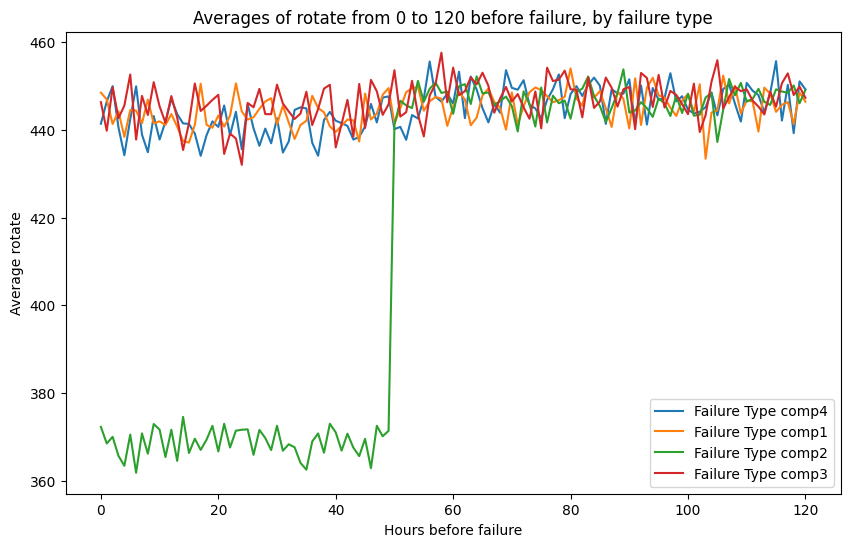

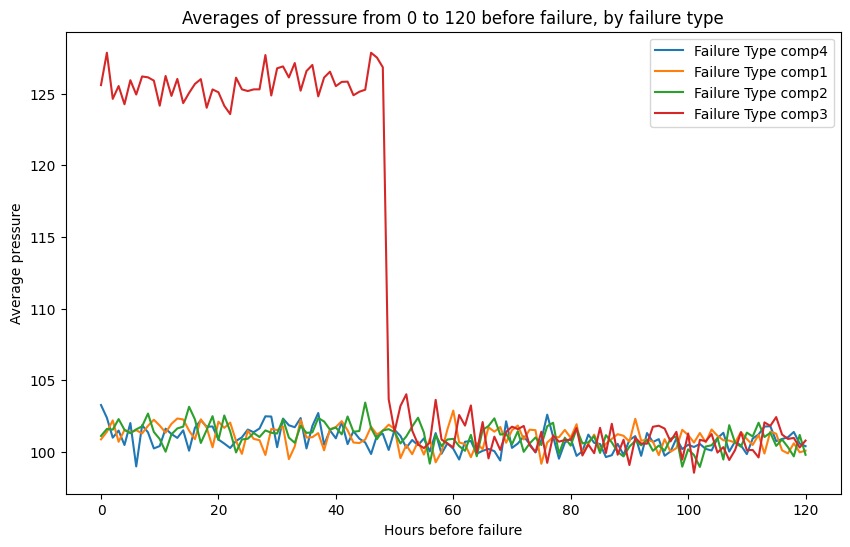

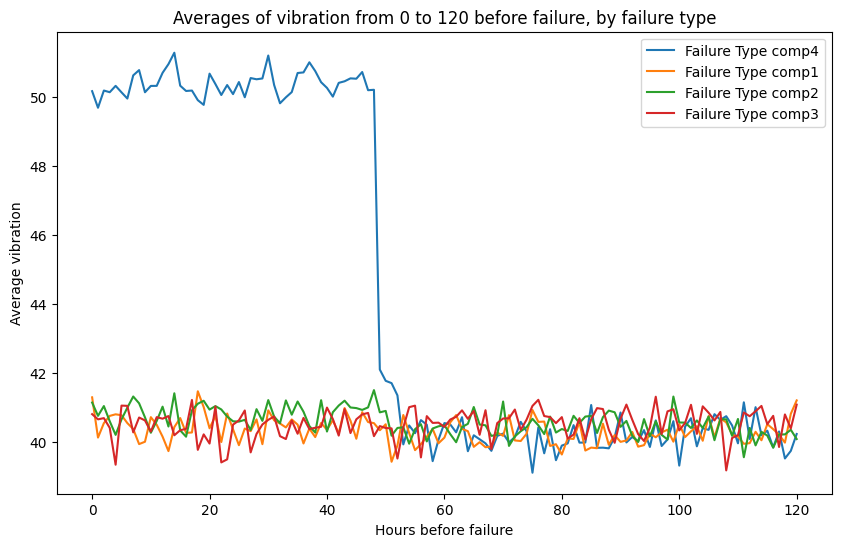

In [5]:
import matplotlib.pyplot as plt

indices = labels[labels["failure"] <= window].index

for column in preprocessed_data.columns:
    plt.figure(figsize=(10, 6))

    for failure_type in unique_failures:
        indices = labels[(labels[failure_type] <= window)].index
        data_to_plot = preprocessed_data.loc[indices, column]
        averages = data_to_plot.groupby(labels.loc[indices, failure_type]).mean()
        plt.plot(averages.index, averages, label=f"Failure Type {failure_type}")

    plt.title(f"Averages of {column} from 0 to 120 before failure, by failure type")
    plt.xlabel("Hours before failure")
    plt.ylabel(f"Average {column}")
    plt.legend()
    plt.show()

- Smoothed data

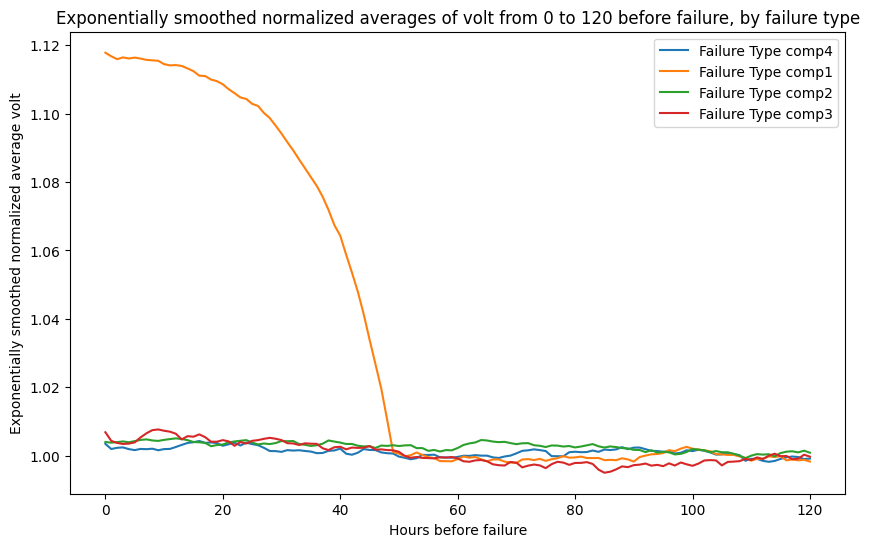

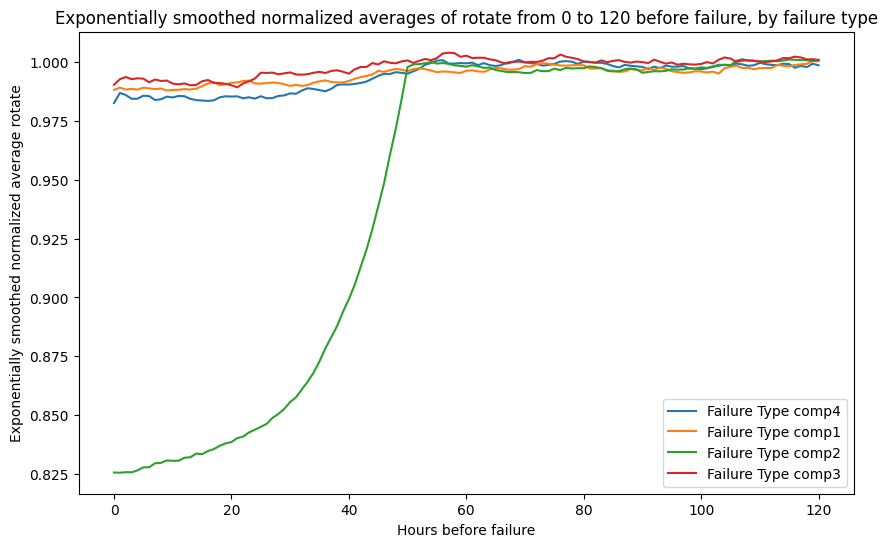

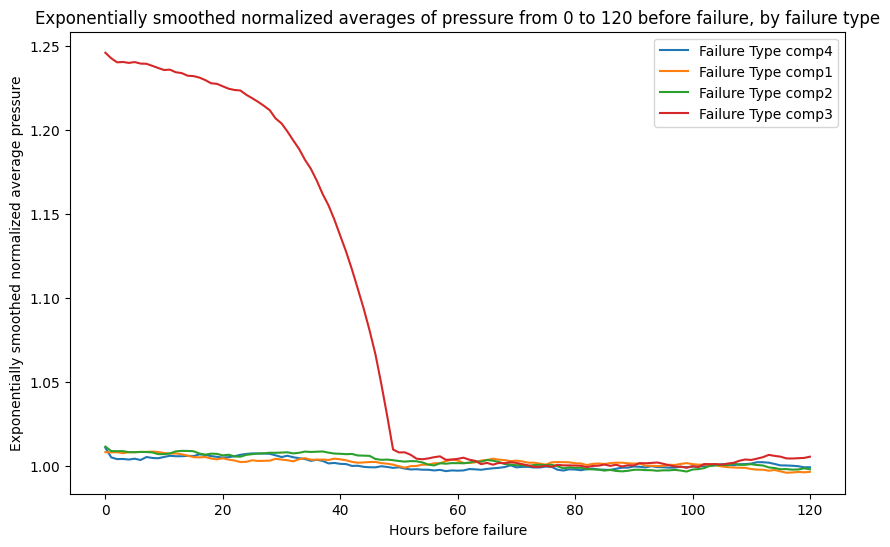

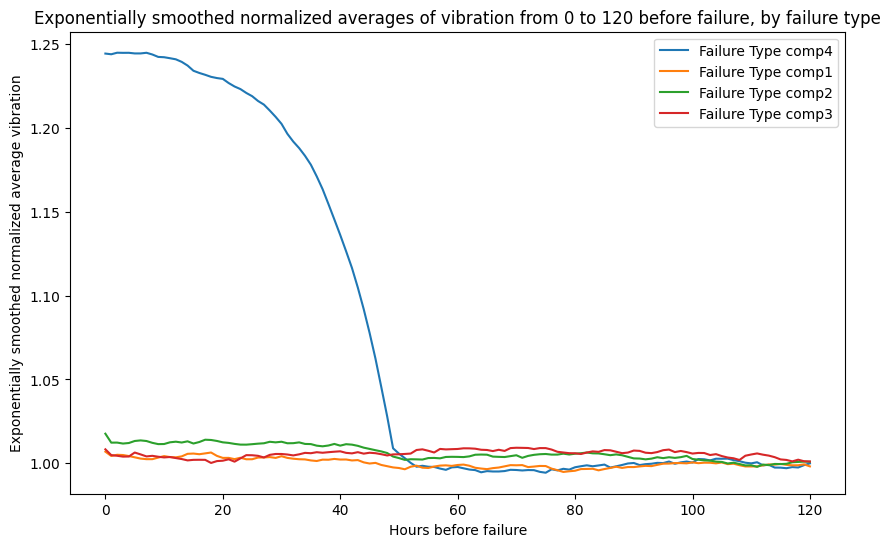

In [6]:
span = 24
normalized_data = preprocessed_data.div(healthy_avgs, axis="columns")
smoothed_data = pd.DataFrame(index=normalized_data.index)

for column in normalized_data.columns:
    plt.figure(figsize=(10, 6))

    smoothed_column_data = normalized_data[column].ewm(span=span, adjust=False).mean()
    smoothed_data[column] = smoothed_column_data

    for failure_type in unique_failures:
        indices = labels[(labels[failure_type] <= window)].index
        data_to_plot = smoothed_column_data.loc[indices]
        averages = data_to_plot.groupby(labels.loc[indices, failure_type]).mean()
        plt.plot(averages.index, averages, label=f"Failure Type {failure_type}")

    plt.title(
        f"Exponentially smoothed normalized averages of {column} from 0 to 120 before failure, by failure type"
    )
    plt.xlabel("Hours before failure")
    plt.ylabel(f"Exponentially smoothed normalized average {column}")
    plt.legend()
    plt.show()

### Model

- Random Forest

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report

STATE = 42
normal_data = smoothed_data[labels["failure_type"] == "normal"]
other_data = smoothed_data[labels["failure_type"] != "normal"]
normal_labels = labels[labels["failure_type"] == "normal"]
other_labels = labels[labels["failure_type"] != "normal"]

max_class_size = other_labels["failure_type"].value_counts().max()

normal_data_downsampled, normal_labels_downsampled = resample(
    normal_data,
    normal_labels,
    replace=False,
    n_samples=max_class_size,
    random_state=STATE,
)

balanced_data = pd.concat([normal_data_downsampled, other_data])
balanced_labels = pd.concat([normal_labels_downsampled, other_labels])

X_train, X_test, y_train, y_test = train_test_split(
    balanced_data, balanced_labels["failure_type"], test_size=0.2, random_state=STATE
)

clf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced")
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.8781757600999583
              precision    recall  f1-score   support

                   0.00      0.00      0.00         7
       comp1       0.89      0.89      0.89      1941
       comp2       0.90      0.92      0.91      2458
       comp3       0.89      0.90      0.90      1206
       comp4       0.89      0.89      0.89      1524
      normal       0.83      0.81      0.82      2468

    accuracy                           0.88      9604
   macro avg       0.73      0.74      0.73      9604
weighted avg       0.88      0.88      0.88      9604



- KNN

In [8]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.8715118700541441
              precision    recall  f1-score   support

                   0.00      0.00      0.00         7
       comp1       0.88      0.90      0.89      1941
       comp2       0.89      0.91      0.90      2458
       comp3       0.89      0.90      0.90      1206
       comp4       0.88      0.89      0.89      1524
      normal       0.83      0.79      0.81      2468

    accuracy                           0.87      9604
   macro avg       0.73      0.73      0.73      9604
weighted avg       0.87      0.87      0.87      9604



In [11]:
from sklearn.svm import SVC

svc = SVC(
    kernel="rbf",
    random_state=STATE,
)
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.8683881715951687
              precision    recall  f1-score   support

                   0.00      0.00      0.00         7
       comp1       0.88      0.89      0.88      1941
       comp2       0.89      0.90      0.89      2458
       comp3       0.88      0.88      0.88      1206
       comp4       0.90      0.84      0.87      1524
      normal       0.82      0.83      0.83      2468

    accuracy                           0.87      9604
   macro avg       0.73      0.72      0.73      9604
weighted avg       0.87      0.87      0.87      9604



## Regression

Failure Type: comp4, Error: 10.58703990592781, R^2: 0.4565328865964031


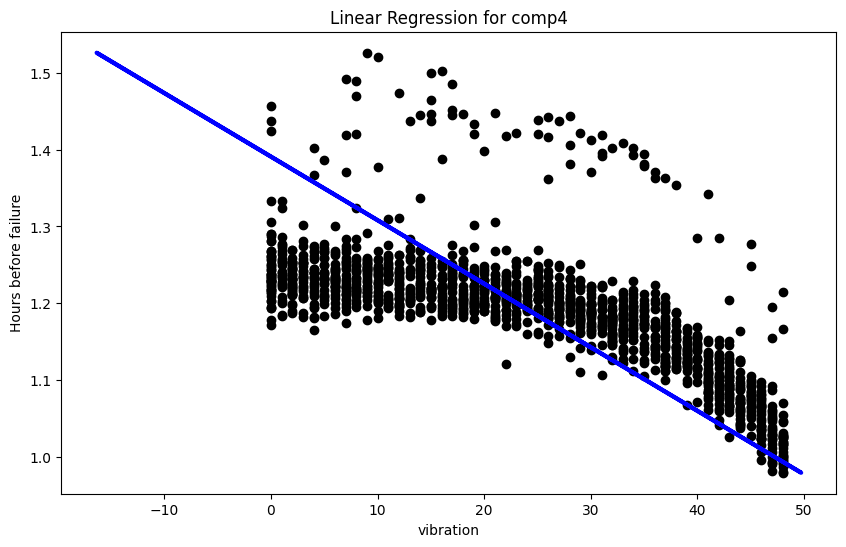

Failure Type: comp1, Error: 10.648463029523313, R^2: 0.4344254908594959


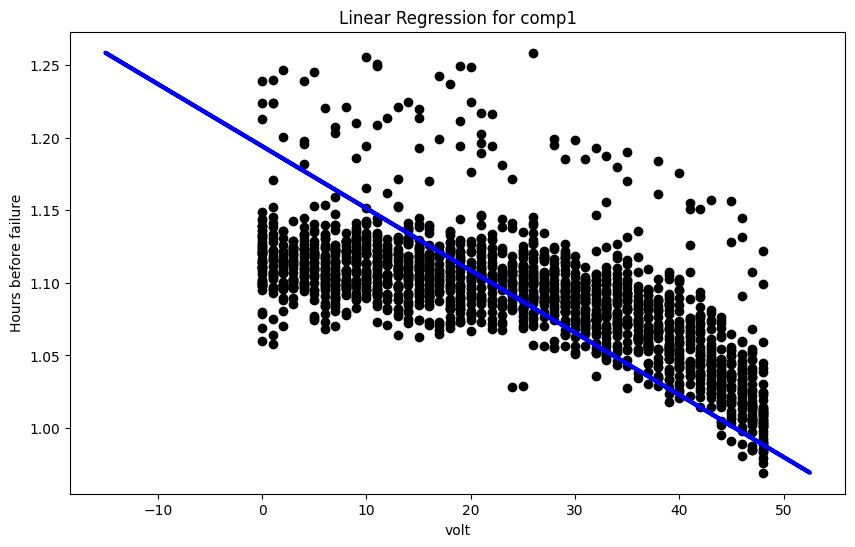

Failure Type: comp2, Error: 10.601323657881885, R^2: 0.4447133403834591


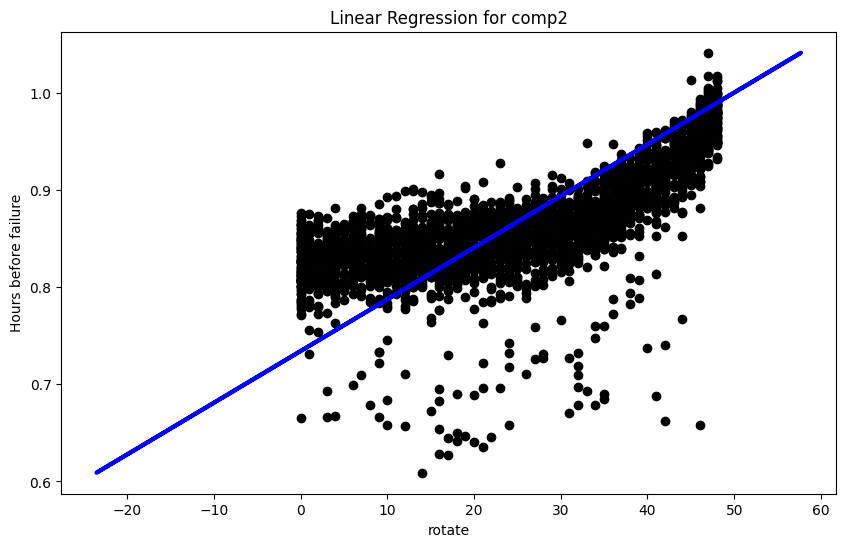

Failure Type: comp3, Error: 10.178696588161761, R^2: 0.48474347279207963


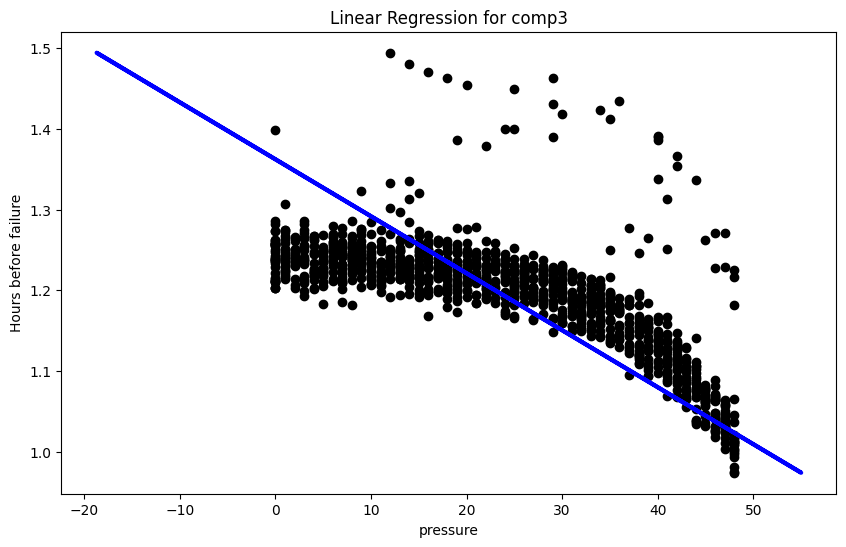

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


filtered_labels = labels[labels["failure"] <= 48]
filtered_data = smoothed_data.loc[filtered_labels.index]
regression_df = pd.concat([filtered_data, filtered_labels], axis=1)
regression_df.to_csv("regression_data.csv", index=False)

failure_dict = {
    "comp1": "volt",
    "comp2": "rotate",
    "comp3": "pressure",
    "comp4": "vibration",
}


def plot(failure_type: str, X: pd.DataFrame, y: pd.Series, y_pred: pd.Series) -> None:
    plt.figure(figsize=(10, 6))
    plt.scatter(y, X, color="black")
    plt.plot(y_pred, X, color="blue", linewidth=3)
    plt.title(f"Linear Regression for {failure_type}")
    plt.xlabel(f"{failure_dict[failure_type]}")
    plt.ylabel("Hours before failure")
    plt.show()


for failure_type in unique_failures:
    indices = filtered_labels[filtered_labels["failure_type"] == failure_type].index
    X = filtered_data.loc[indices, [failure_dict[failure_type]]]
    y = filtered_labels.loc[indices, failure_type]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=STATE
    )

    model = LinearRegression(n_jobs=-1)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    y_pred_df = pd.DataFrame(y_pred, columns=["Predicted"])
    X_test_reset = X_test.reset_index(drop=True)
    y_test_reset = y_test.reset_index(drop=True)

    print(f"Failure Type: {failure_type}, Error: {mse**(1/2)}, R^2: {r2}")
    plot(failure_type, X_test_reset, y_test_reset, y_pred_df)

In [13]:
for failure_type in unique_failures:
    indices = filtered_labels[filtered_labels["failure_type"] == failure_type].index
    X = filtered_data.loc[indices, [failure_dict[failure_type]]]
    y = filtered_labels.loc[indices, failure_type]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=STATE
    )

    best_degree = None
    best_mse = float("inf")
    best_model = None

    for degree in range(1, 100):
        model = make_pipeline(PolynomialFeatures(degree), LinearRegression(n_jobs=-1))
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)

        if mse < best_mse:
            best_mse = mse
            best_degree = degree
            best_model = model
            r2 = r2_score(y_test, y_pred)
    print(
        f"Failure Type: {failure_type}, Best Degree: {best_degree}, Error: {best_mse**(1/2)}, R^2: {r2}"
    )

Failure Type: comp4, Best Degree: 21, Error: 8.039466056435751, R^2: 0.6866147292324721
Failure Type: comp1, Best Degree: 8, Error: 9.406570109403095, R^2: 0.5586546391218026
Failure Type: comp2, Best Degree: 48, Error: 8.942665682936388, R^2: 0.6048781533226246
Failure Type: comp3, Best Degree: 17, Error: 7.885859413274745, R^2: 0.6907304054562268


In [23]:
from sklearn.neural_network import MLPRegressor


for failure_type in unique_failures:
    indices = filtered_labels[filtered_labels["failure_type"] == failure_type].index
    X = filtered_data.loc[indices, [failure_dict[failure_type]]]
    y = filtered_labels.loc[indices, failure_type]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=STATE
    )
    model = MLPRegressor(
        hidden_layer_sizes=(100,100,100),
        max_iter=1000,
        random_state=STATE,
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Failure Type: {failure_type}, Error: {best_mse**(1/2)}, R^2: {r2}")

Failure Type: comp4, Error: 7.885859413274745, R^2: 0.6707858920704675
Failure Type: comp1, Error: 7.885859413274745, R^2: 0.5320423109440842
Failure Type: comp2, Error: 7.885859413274745, R^2: 0.5833397233757439
Failure Type: comp3, Error: 7.885859413274745, R^2: 0.6697733469637959
